# RNNによる時系列データの学習

In [ ]:
#Colaboratory環境の設定
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/稲伸ゼミナール/共有/python教室/河原電子ビジネス専門学校/lecture_2024/deep_learning2024/学生共有用/24_for_staff


Mounted at /content/drive
/content/drive/MyDrive/稲伸ゼミナール/共有/python教室/河原電子ビジネス専門学校/lecture_2024/deep_learning2024/学生共有用/24_for_staff


## 音の分類のためにデータを前処理してみよう

In [2]:
import librosa
import pandas as pd
import numpy as np
import IPython.display as ipd

#学習データの読み込み
train_data_dir ="./audio_dataset_3class/train/"
train_df = pd.read_csv("audio_dataset_3class/train.csv", index_col=0)

#テストデータの読み込み
test_data_dir ="./audio_dataset_3class/test/"
test_df = pd.read_csv("audio_dataset_3class/test.csv", index_col=0)


In [3]:
#学習に使うデータの音声ファイル名とラベルの1部を表示する
train_df.head()

,label
fname,
969b4f60.wav,Cello
3e2bddda.wav,Cello
54bb57af.wav,Cello
9d59a719.wav,Applause
05f2c2a6.wav,Clarinet


In [4]:
#ラベルに使われている値とその数の一覧を表示
train_df["label"].value_counts()

label
Clarinet    130
Cello       125
Applause     61
Name: count, dtype: int64

In [5]:
#チェロの音声データのうちの一つを読み込む
data, rate = librosa.load(train_data_dir+ train_df[train_df["label"] == "Cello"].index[0])

#読み込んだデータを再生する
ipd.Audio(data = data, rate = rate)

In [ ]:
#読み込んだチェロの音声データの形を確認
print(data.shape)
data

(113337,)


array([ 5.3411443e-04,  8.4143248e-04,  1.0000727e-03, ...,
       -3.0440140e-05, -2.3922354e-05, -1.2577169e-05], dtype=float32)

In [7]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences


sampling_rate = 8000
#音の長さを3秒に切り取る
audio_duration = 3
audio_length = sampling_rate * audio_duration

#ファイル名から音声データを読み込む
def _load_files(data_dir, filenames):
  result = []
  for i, filename in enumerate(filenames):
        file_path = data_dir + filename
        data, _ = librosa.core.load(file_path, sr=sampling_rate, res_type='kaiser_fast')
        result.append(data)

  return result


def create_audio_dataset(train_df, test_df, train_data_dir, test_data_dir, label_dict):

    dim = (audio_length, 1)
    train_filenames = train_df.index
    test_filenames = test_df.index

    #学習用データとテスト用データの音声ファイルをファイル名から読み込む
    _X_train = _load_files(train_data_dir, train_filenames)
    _X_test = _load_files(test_data_dir, test_filenames)

    #audio_length(ここでは3秒)に音の長さを揃える
    _X_train = pad_sequences(_X_train, dtype='float32', maxlen=audio_length, padding='pre', truncating='pre', value=0.0).tolist()
    _X_test = pad_sequences(_X_test, dtype='float32', maxlen=audio_length, padding='pre', truncating='pre', value=0.0).tolist()

    #音のデータをStandardScalerで平均値を0、分散を１に補正する
    scaler = StandardScaler()
    scaler = scaler.fit(_X_train + _X_test)
    _X_train = scaler.transform(_X_train)
    _X_test = scaler.transform(_X_test)

    X_train = np.empty((len(train_filenames), *dim))
    for index, data in enumerate(_X_train):
      X_train[index,] = [[d] for d in data]

    X_test = np.empty((len(test_filenames), *dim))
    for index, data in enumerate(_X_test):
      X_test[index,] = [[d] for d in data]


    #以下からはlabelの作成
    labels_train = train_df["label"]
    labels_test = test_df["label"]

    y_train = np.empty(len(labels_train), dtype=int)
    for i, label in enumerate(labels_train):
        y_train[i] = label_dict[label]

    y_test = np.empty(len(labels_test), dtype=int)
    for i, label in enumerate(labels_test):
        y_test[i] = label_dict[label]

    #one-hot encodingする
    Y_train = to_categorical(y_train, num_classes=len(label_dict))
    Y_test = to_categorical(y_test, num_classes=len(label_dict))

    return X_train, Y_train, X_test, Y_test


audio_label_dict = {"Cello": 0,"Clarinet":1, "Applause":2}
X_train, Y_train, X_test, Y_test = create_audio_dataset(train_df, test_df, train_data_dir, test_data_dir, audio_label_dict)

## LSTMで音の分類をしてみよう

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Dropout,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def create_lstm_model():
  input_shape = (audio_length, 1)

  #モデルの構築
  model_lstm = Sequential()
  model_lstm.add(LSTM(64, return_sequences=True, dropout=0.3 ,input_shape=input_shape))
  model_lstm.add(LSTM(64, return_sequences=False, dropout=0.3))
  model_lstm.add(Dense(units=len(audio_label_dict), activation="softmax"))
  model_lstm.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=["acc"])
  return model_lstm

model_lstm = create_lstm_model()
#モデルの構造を表示する
model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24000, 64)           │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,115 (195.76 KB)

 Trainable params: 50,115 (195.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#学習開始
history = model_lstm.fit(X_train, Y_train, batch_size=16, epochs=40, validation_split=0.1, verbose=1)

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - acc: 0.3740 - loss: 1.0948 - val_acc: 0.4375 - val_loss: 1.0798
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - acc: 0.3404 - loss: 1.0678 - val_acc: 0.4688 - val_loss: 1.0378
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - acc: 0.4208 - loss: 1.0439 - val_acc: 0.4375 - val_loss: 1.0343
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.4332 - loss: 1.0451 - val_acc: 0.4688 - val_loss: 0.9978
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.4464 - loss: 1.0593 - val_acc: 0.5312 - val_loss: 0.9954
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.4624 - loss: 1.0029 - val_acc: 0.4688 - val_loss: 1.0057
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - acc: 0.4328 - loss: 1.0121 - val_acc: 0.4688 - val_loss: 0.9927
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.4209 - loss: 1.0353 - val_acc: 0.4375 - val_loss: 0.9834
Epoch 9/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - acc: 0.4602 - loss: 

In [ ]:
#学習に時間がかかるため、以下のコードのコメントアウトを外すことでモデルの重みの保存と読み込みが出来ます.
#１度保存しておき、8節以降をあとから実行する場合保存したモデルの重みを読み込むことで学習を再実行しなくて済みます

#モデルの重みの保存
#model_lstm.save_weights('./saved_models/model_lstm_weights')

In [ ]:
#保存したモデルの読み込み
#model_lstm = create_lstm_model()
#model_lstm.load_weights('./saved_models/model_lstm_weights')

## LSTMで分類した結果を評価してみよう

In [ ]:
#予測開始
predictions = model_lstm.predict(X_test, verbose=1)
pred_labels = np.array([np.argmax(pred) for pred in predictions])
actual_labels = np.array([audio_label_dict[lab] for lab in test_df["label"]])

#正答率の算出
tmp = actual_labels == pred_labels
tmp.sum()/len(tmp)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 770ms/step


0.45774647887323944

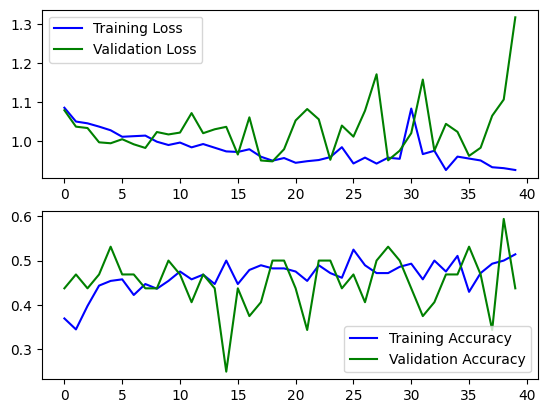

In [ ]:
import matplotlib.pyplot as plt

#評価関数と精度のグラフ表示
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history["loss"], color="b", label="Training Loss")
ax[0].plot(history.history["val_loss"], color="g", label="Validation Loss")
ax[0].legend()

ax[1].plot(history.history["acc"], color="b", label="Training Accuracy")
ax[1].plot(history.history["val_acc"], color="g", label="Validation Accuracy")
ax[1].legend()

plt.show()

[]

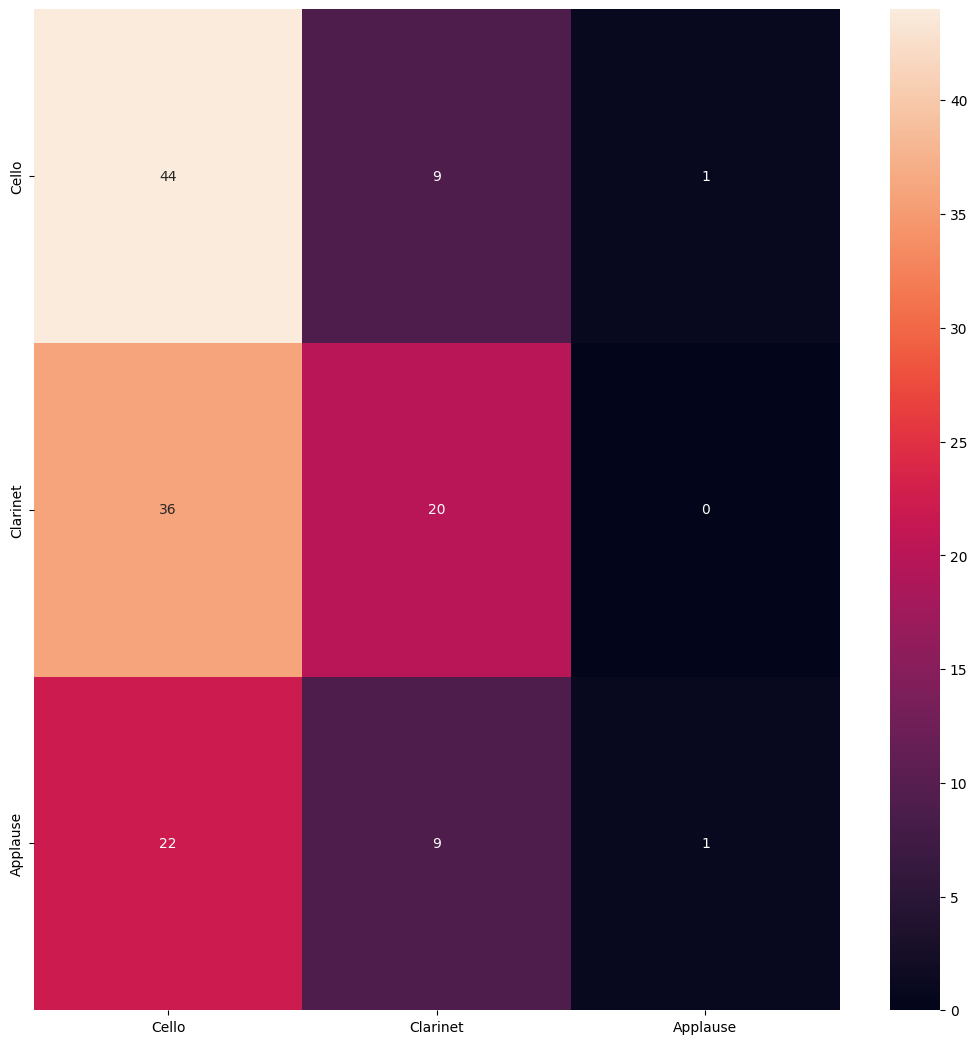

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#混同行列の作成
cf_matrix = confusion_matrix(actual_labels, pred_labels)

plt.figure(figsize=(13,13))
c = sns.heatmap(cf_matrix, annot=True, fmt="d")

#audio_label_dict = {"Cello": 0,"Clarinet":1, "Applause":2}
audio_label_list = ["Cello", "Clarinet", "Applause"]
c.set(xticklabels=audio_label_list, yticklabels=audio_label_list)
plt.plot()

## おまけ　CNNで音の分類

In [14]:
from tensorflow.keras.layers import Activation, Conv1D, MaxPooling1D, GlobalMaxPool1D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense


def create_cnn_model():
  #モデルの構築
  input_shape = (audio_length, 1)
  model_cnn = Sequential()
  model_cnn.add(Conv1D(filters=128, kernel_size=9, padding='valid', input_shape=input_shape, activation='relu'))
  model_cnn.add(MaxPooling1D(pool_size=16))
  model_cnn.add(Dropout(rate=0.2))
  model_cnn.add(Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu'))
  model_cnn.add(GlobalMaxPool1D())
  model_cnn.add(Dropout(rate=0.2))
  model_cnn.add(Dense(len(audio_label_dict), activation="softmax"))
  model_cnn.compile(optimizer=Adam(0.0001), loss="categorical_crossentropy", metrics=['acc'])
  return model_cnn

model_cnn = create_cnn_model()
#モデルの構造を表示する
model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 23992, 128)     │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1499, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1499, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1497, 64)       │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,115 (102.01 KB)

 Trainable params: 26,115 (102.01 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model_cnn.fit(X_train, Y_train, batch_size=16, epochs=50, validation_split=0.1, verbose=1)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - acc: 0.4303 - loss: 1.0980 - val_acc: 0.4062 - val_loss: 1.0605
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - acc: 0.4031 - loss: 1.0790 - val_acc: 0.5312 - val_loss: 0.9799
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - acc: 0.5172 - loss: 0.9433 - val_acc: 0.5625 - val_loss: 0.9467
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - acc: 0.5682 - loss: 0.9500 - val_acc: 0.5938 - val_loss: 0.9195
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - acc: 0.6348 - loss: 0.9539 - val_acc: 0.6562 - val_loss: 0.8836
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - acc: 0.5753 - loss: 0.9155 - val_acc: 0.7812 - val_loss: 0.8609
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - acc: 0.6036 - loss: 0.8516 - val_acc: 0.8125 - val_loss: 0.8402
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - acc: 0.6680 - loss: 0.8835 - val_acc: 0.7812 - val_loss: 0.8187
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - ac

## CNNで分類した結果を評価してみよう

In [16]:
#予測開始
predictions = model_cnn.predict(X_test, verbose=1)
pred_labels = np.array([np.argmax(pred) for pred in predictions])
actual_labels = np.array([audio_label_dict[lab] for lab in test_df["label"]])

#正答率の算出
tmp = actual_labels == pred_labels
tmp.sum()/len(tmp)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


np.float64(0.7605633802816901)

In [17]:
#評価関数と精度のグラフ表示
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history["loss"], color="b", label="Training Loss")
ax[0].plot(history.history["val_loss"], color="g", label="Validation Loss")
ax[0].legend()

ax[1].plot(history.history["acc"], color="b", label="Training Accuracy")
ax[1].plot(history.history["val_acc"], color="g", label="Validation Accuracy")
ax[1].legend()

plt.show()

NameError: name 'plt' is not defined

In [ ]:
#混同行列の作成
cf_matrix = confusion_matrix(actual_labels, pred_labels)

plt.figure(figsize=(13,13))
c = sns.heatmap(cf_matrix, annot=True, fmt="d")

#audio_label_dict = {"Cello": 0,"Clarinet":1, "Applause":2}
audio_label_list = ["Cello", "Clarinet", "Applause"]
c.set(xticklabels=audio_label_list, yticklabels=audio_label_list)
plt.plot()